# sustainability_topic_modeling

In [1]:
#Load in nlp pipeline

#import sustainability_nlp_pipeline
from sustainability_nlp_pipeline import nlp_pipeline as nlp_func
from sustainability_nlp_pipeline import cleaned_text

In [2]:
#Load in other packages

import re
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD

In [130]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Connect to MongoDB

from pymongo import MongoClient
client = MongoClient()
db = client.environment
sustainability_collection = db.sustainability

Create Regex Pattern Specific to Twitter Language:

In [4]:
'''

Tweet Tokenizer Adapted from :  https://github.com/adonoho/TweetTokenizers/blob/master/PottsTweetTokenizer.py
   
This Tokenizer preserves Twitter language including:  usernames, hashtags, symbols html, etc.

'''

regex_code = (

    r"""(?:<[^>]+>)""",                             # HTML tags
    r"""(?:http[s]?://t.co/[a-zA-Z0-9]+)""",        # URLs 
    r"""(?:http[s]\S+?)""",                         # URLs
    r"""(?:@[\w_]+)""",                             # Twitter username
    r"""(?:\#+[\w_]+[\w\'_\-]*[\w_]+)""",           # Twitter hashtags
    r"""(?:\$[a-zA-Z]{1,6}([._][a-zA-Z]{1,2})?)""", # Twitter symbols / cashtags
    r"""(?:[a-z][a-z'\-_]+[a-z])""",                # Words with apostrophes or dashes
    r"""(?:[+\-]?\d+[,/.:-]\d+[+\-]?)""",           # Numbers, including fractions, decimals
    r"""(?:[\w_]+)""",                              # Words without apostrophes or dashes
    r"""(?:\.(?:\s*\.){1,})"""                      # Ellipsis
    )

#regex_text = re.sub(r'[%s]'% (regex_pattern), ' ')

regex_pattern = re.compile(r"""(%s)"""%"|".join(regex_code), re.VERBOSE | re.I | re.UNICODE)

In [5]:
print(regex_pattern.pattern)

((?:<[^>]+>)|(?:http[s]?://t.co/[a-zA-Z0-9]+)|(?:http[s]\S+?)|(?:@[\w_]+)|(?:\#+[\w_]+[\w\'_\-]*[\w_]+)|(?:\$[a-zA-Z]{1,6}([._][a-zA-Z]{1,2})?)|(?:[a-z][a-z'\-_]+[a-z])|(?:[+\-]?\d+[,/.:-]\d+[+\-]?)|(?:[\w_]+)|(?:\.(?:\s*\.){1,}))


In [6]:
regex_tokenizer = RegexpTokenizer(pattern=regex_pattern.pattern,gaps=True, discard_empty = True)

Define Stop Words:

In [7]:
stop_words = stopwords.words('english')

#Add additional stop words in here:

additional_stop_words = ['RT', 'rt', "’"]

total_stop_words = stop_words + additional_stop_words

In [8]:
english_cursor = sustainability_collection.aggregate([{'$match': {'lang': 'en'}},{'$sample':{'size':5}}])

In [9]:
for tweet in english_cursor:
    print (tweet['text'])

#author  #JosephKeon; is a wellness consultant, nutrition and fitness expert.  #BreastCancer,  #Breast,  #Cancer,… https://t.co/Mbj8Zt5L8g
RT @BCCCC: The leadership skills of #CSR professionals are more critical than ever as corporate citizenship increasingly becomes an essenti…
RT @Bola_Sol: While I love this, I hope there’s sustainability in us being visible to society. 

We aren’t here for a period of time. We ar…
RT @UrbanFutureConf: Good read about some of the world's most #SustainableCities and their #SustainableBuildings. 🏙️

#Oslo #Seattle #Bogot…
#Sustainability News - Borrowing without debt sustainability framework dangerous – World Bank… https://t.co/CqdpVCDHu8


**Define Parameters to use in NLP Function**

In [10]:
#TF-IDF

nlp_tfidf = nlp_func(vectorizer=TfidfVectorizer(min_df=0, max_df=0.5), cleaning_function=cleaned_text, tokenizer=TreebankWordTokenizer().tokenize, stemmer=PorterStemmer())

In [11]:
english_cursor = sustainability_collection.aggregate([{'$match': {'lang': 'en'}},{'$sample':{'size':5}}])

for tweet in english_cursor:
    nlp_tfidf.fit_vectorizer(tweet['text'])
    vectorized_tweets_tfidf = nlp_tfidf.transform_vectorizer(tweet['text']).toarray()

In [12]:
vectorized_tweets_tfidf

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,

In [13]:
#Count Vectorizer

nlp_cv = nlp_func(vectorizer=CountVectorizer(), cleaning_function=cleaned_text, tokenizer=TreebankWordTokenizer().tokenize, stemmer=PorterStemmer())

In [14]:
english_cursor = sustainability_collection.aggregate([{'$match': {'lang': 'en'}},{'$sample':{'size':5}}])

for tweet in english_cursor:
    nlp_cv.fit_vectorizer(tweet['text'])
    vectorized_tweets_cv = nlp_cv.transform_vectorizer(tweet['text']).toarray()

In [15]:
vectorized_tweets_cv

array([[0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [16]:
CountVectorizer.get_feature_names

<function sklearn.feature_extraction.text.CountVectorizer.get_feature_names(self)>

In [17]:
nlp_cv.get_features()

In [18]:
#screw the pipeline i need to get this to work

In [19]:
english_cursor = sustainability_collection.aggregate([{'$match': {'lang': 'en'}}])

for tweet in english_cursor:
    print(cleaned_text(tweet['text'],tokenizer=TreebankWordTokenizer().tokenize, stemmer=PorterStemmer()))

['angelurena', 'visit', 'conclud', 'week', 'stop', 'miami', 'caribbean', 'presid', 'billclinton', 'promot', 'sustain', 'r…']
['melbourn', 'sydney', 'join', 'us', 'spfaustralia', 'learn', 'latest', 'trend', 'eh', 'riskmanagement…']
['vienna', 'well', 'qualityoflif', 'rank', 'affordableh', 'publictransport', 'sustain']
['aplship', 'apl', 'achiev', '507', 'reduct', 'co2', 'emiss', 'per', 'transport', 'contain', 'per', 'kilometr', '2017', 'compar', '2009', 'read…']
['amazonwatch', '“', 'hydroelectr', 'may', 'appear', 'rel', 'clean', 'process', 'megadam', 'built', 'far', 'belomonte…']
['cleanairgurgaon', 'right', 'clean', 'enviorn', 'also', 'come', 'immens', 'respons', 'ascitizen', 'consumersproducersw', 'thank', 'ha…']
['thefishsit', 'new', 'studi', 'suggest', 'seafood', 'consum', 'across', 'globe', 'unit', 'think', 'biggest', 'threat', 'ocean', 'po…']
['rsborg', 'hear', 'new', 'partnership', 'qldrfa', 'well', 'work', 'togeth', 'support', 'sustain', 'certif', 'fo…']
['newenglanddairi', 'ti

['abdulelsay', 'victori', 'today', 'work', 'continu', 'congratul', 'gretchenwhitm', 'primari', 'win', 'tomorro…']
['alexverbeek', '🌎', '4', 'innov', 'way', 'peopl', 'reus', 'plastic', 'rather', 'throw', 'away', 'plastic', 'zeroplast', 'innovatio…']
['willoughbyc', 'gailgilesgidney', 'also', 'peopl', 'go', 'internet', 'know', 'theyr', 'look', 'i…']
['kashthefuturist', 'doctor', 'warn', 'plasticpollut', 'kill', 'human', 'race', 'sustain', 'climatechang', 'plastic', 'wast', 'sdg', 'ci…']
['love', 'shot', 'stellathelight', 'enjoy', 'soft', 'amp', 'easi', 'slide', 'beauti', 'day', 'ethicalfashion…']
['amazonwatch', '“', 'hydroelectr', 'may', 'appear', 'rel', 'clean', 'process', 'megadam', 'built', 'far', 'belomonte…']
['south', 'west', 'builder', 'lead', 'way', 'environment', 'sustain']
['openpackaginnet', 'readi', 'sustain', 'blockchain', 'let', 'talk', 'one', 'time', 'blockchain', 'packag', 'industry…']
['willoughbyc', 'gailgilesgidney', 'pamphlet', 'provid', 'council', 'pickup', 'could',

['pamkeithfl', 'result', 'polici', 'base', 'short', 'term', 'greed', 'long', 'term', 'sustain', 'let', 'gop', 'control', 'al…']
['hpapontario', 'billyjoecain', 'exactli', 'need', 'keep', 'econom', 'leg', 'sustain', 'stool', 'strong', 'people…']
['iudicatepauperi', 'dear', 'mojgovuk', 'understand', 'new', 'buzz', 'word', 'sustain', 'penni', 'final', 'forgiv', 'cynic', 'b…']
['consid', 'solar', 'get', 'discount', 'expir', 'nov', '10th', 'regist', 'onlin', 'san', 'mateo', 'sunshar', 'program…']
['leespivak', 'realli', 'enjoy', 'attend', 'allstargam', 'evalu', 'mlb', 'councilforsport', 'certif', 'effort', 'make', 'video…']
['eumar', '2', 'week', 'world', 'aquacultur', 'commun', 'gather', 'montpelli', '🇫🇷', '2529', 'august', 'high', 'qualiti', 'amp', 'sustain…']
['greenhash', 'want', 'know', '2018', 'crypto', 'see', 'massiv', 'shift', 'awar', 'mathemat', 'race', 'mine', 'limit', 'elit', 'amp', 'techie…']
['koborigrillscsr', 'sustain', 'team', 'levistraussco', 'hire', 'analyst', 'posit', 'sa

['mikehudema', 'manufactur', 'solar', 'panel', 'caus', 'pollut', 'need', 'think', 'save', 'planet', 'life', 'as…']
['drsharwood', 'circuitari', 'advanc', 'technolog', 'structur', 'natur', 'materi', 'digit', 'tech', 'ai', 'vr', 'su…']
['ht', 'mikequindazzi', '5', 'set', 'emergingtech', 'advanc', 'climateact', 'solut', 'gtgt', 'mikequindazzi', 'gtgt', 'ai', 'cloud', 'iot…']
['myviralexposur', '🔥🌐', 'retweet', 'share', 'support', '🌐🔥', 'scottha55665467', 'crisi', 'nicaragua', 'sosnicaragua', 'sustain', 'viralexpnotifi', 'gofun…']
['barefxxtjim', '13', 'low', 'care', 'deepli', 'health', 'safeti', 'custom', 'serv', 'work', 'merch…']
['hungrycomrad', 'dont', 'mandat', 'subsist', 'via', 'sustain', 'everyon', 'get', 'plot', 'food', 'water', 'cat…']
['creat', 'safespaces4youth', 'sustain', 'futur', 'debt', 'predict', 'safe', 'futur', 'yout…']
['solvemit', '“', 'except', 'entrepreneur', 'oceti', 'sakowin', 'gather', 'today', 'monday', 'solv', 'stand', 'rock', 'celebr', 'uplift…']
['philipshortla

['batterseanet', 'top', 'stori', 'ell', 'uk', 'dedic', 'septemb', 'issu', 'sustain', 'see']
['tmbrhncr', 'manufactur', 'europ', 'special', 'ecofriendli', 'musicrel', 'stuff', 'vinyl', 'cd', 'mc', 'merch', 'poster', 'etc', 'sus…']
['evankirstel', '5foot', 'robot', 'snake', 'design', 'find', 'sourc', 'pollut', 'contamin', 'water', 'robot', 'environmentprotecti…']
['ucwat', 'want', 'learn', 'student', 'staff', 'ucsc', 'hydrogeolog', 'lab', 'research', 'groundwat', 'watch', 'their…']
['crestrestravel', 'get', 'lost', 'oasi', 'relax', 'bucuti', 'locat', 'aruba', 'eagl', 'beach', 'platinum', 'sponsor', 'bucuti', 'amp', 'tara', 'a…']
['hi', 'jamesrobey', 'sustain', 'hot', 'topic', 'levelup', 'capgeminina', 'capgemini', 'csrleadershipsummit', 'and…']
['type', 'cabl', 'car', 'ropeway', 'procur', 'report', 'sustain', 'procur', 'insight', 'avail']
['energi', 'save', 'tip', '52', 'see', 'moistur', 'collect', 'feel', 'cold', 'air', 'around', 'close', 'refriger', 'door', 'mi…']
['paper', 'recycl', '

['nelbahja', 'simpl', 'drop', 'creat', 'rippl', 'simpl', 'thought', 'gest', 'word', 'action', 'make', 'differ', 'human', 'sensit', 'menta…']
['equiltweet', 'much', 'look', 'forward', 'year', 'environment', 'film', 'festiv', 'compel', 'program', 'film', 'effaau', 'detail', 'h…']
['verdegreenteam', 'reusabl', 'contain', 'lunch', 'box', 'readi', 'schoolsustain', 'greenschool', 'zerowast', 'reus', 'reduc', 'reducereuser…']
['yahoocountri', 'usa', 'need', 'think', 'earth', 'amp', 'futur', 'w', 'ocean', 'warm', 'east', 'coast', 'popul', 'boom', 'high', 'acid', 'ks', 'soil…']
['sumanthc', 'carboncoach', 'shine', 'light', 'carbonfootprint', 'enabl', 'consum', 'make', 'better', 'purchas', 'decis', 'sustainabilit…']
['renew', 'renewableenergi', 'sustain', 'wwf', 'energi', 'climatechang', 'emiss', 'emiss', 'go', 'wwf', 'no…']
['sustainablysti', 'ell', 'uk', 'dedic', 'septemb', 'issu', 'sustain', 'woot', 'sustain', 'uk']
['carboncoach', 'shine', 'light', 'carbonfootprint', 'enabl', 'consum', 'make

['upsnew', 'check', 'newest', 'edit', 'up', 'horizon', 'sustain', 'newslett', 'creat', 'offer', 'up', 'perspect', 'sustainabili…']
['adam', 'siegel', 'senior', 'vice', 'presid', 'researchinnov', 'sustain', 'retail', 'industri', 'leader', 'ass…']
['shyam17', 'indian', 'fishermen', 'take', 'plastic', 'sea', 'use', 'build', 'road', 'keralaplasticsrecycling…']
['gen', 'europ', 'ecopreneur', 'climat', 'english', 'lush', 'uk', 'greenpeac', 'uk', 'friend', 'earth…']
['share', 'agre', 'electr', 'soon', 'made', 'peopl', 'peopl', 'blockchain', 'renewables…']
['musadaqz', 'interloop', 'launch', 'campaign', 'plant', 'pakistan', '73rd', 'independ', 'day', 'pakistan', 'join', 'hand', 'us', 'part', 'gre…']
['buseconymohg', 'son', 'daughter', 'go', 'iceland', 'supermarket', 'start', 'gallop', 'ahead', 'environmentalissu']
['moisturevapor8r', 'natgeo', 'worldelephantday2018', 'agre', 'natgeo', 'mani', 'worthi', 'voic', 'protect', 'eleph', 'wef', 'shared…']
['ecosia', 'want', 'plant', 'tree', 'ecosia', 

['lidl', 'seel', '5kg', 'box', 'wonki', 'fruit', 'veg', '£150', 'foodwast', 'wast', 'fruit…']
['aumanufactur', 'digitalis', 'facilit', 'circular', 'economi', 'join', 'convers', 'aumanufacturi…']
['enjoy', '2', 'visit', 'buffalo', 'tx', 'dickey', 'bbq', 'drive', 'dfw', 'hou', 'gr8', 'food', 'amp', 'servic', 'but…']
['kaigrunwitz', '👉', 'busi', 'societi', 'need', 'smartciti', 'surviv', 'great', 'articl', '👍', 'ishers123', '👏', 'urban', 'iot', 'sustaina…']
['renew', 'renewableenergi', 'sustain', 'energi', 'climatechang', 'wwf', 'emiss', 'wwf', '15', '15', 'wrong', 'see']
['kashthefuturist', 'world', 'tackl', 'plastic', 'problem', 'sustain', 'climatechang', 'plastic', 'wast', 'circulareco…']
['latest', 'fashion', 'daili', 'thank', 'alishajane777', 'rondonaho', 'thekindcraft', 'sustain', 'portland']
['duflotvaleria', 'scientist', 'discov', 'game', 'chang', 'enzym', 'break', 'plastic', 'day', '😍😍😍', 'plasticfre', 'innov', 'te…']
['one', 'largest', 'buyout', 'privateequ', 'firm', 'india', 'en

['understand', 'benefit', 'align', 'sustain', 'develop', 'goal', 'contact', 'bambuddha', 'group', 'today', 'our…']
['newscience101', 'innov', 'use', 'raindrop', 'power', 'wearabl', 'portabl', 'electron', 'materialsscie…']
['unpreced', 'growth', 'irish', 'energi', 'sector', 'light', 'new', 'government', 'support', 'green', 'energi', 'ireland', 'see…']
['pumpkin', 'seed', 'custard', 'almond', 'amp', 'caramel', 'ownproduct', 'honey', 'amass', 'copenhagen', 'sfreelifecph', 'amass…']
['duflotvaleria', 'franc', '🇫🇷', 'ban', 'shop', 'throw', 'away', 'unsold', 'food', 'cloth', 'instead', 'donat', 'chariti', 'circulareconomi', '…']
['enenergi', 'renew', 'renewableenergi', 'sustain', 'wwf', 'emiss', 'climatechang', 'energi', 'emiss', 'go', 'wwf', 'falling…']
['time', 'pollut', 'game', 'comment', 'guess', 'identifi', 'piec', 'plastic', 'pollut', 'found', 'today', 'newcastl…']
['newscience101', 'innov', 'use', 'raindrop', 'power', 'wearabl', 'portabl', 'electron', 'materialsscie…']
['kashthefuturi

['gsiaru', 'great', 'resourc', 'guid', 'subject', 'area', 'efsaru', 'team', '✌️educationforsustain', 'sustainablestud']
['spoton', '“', 'educ', 'custom', 'invest', 'get', 'make', 'peopl', 'variou', 'nation', 'amp', 'protect…']
['glengilmor', '❤️', '🚲', '🚲', '🚲', 'japan', '🇯🇵', 'autom', 'bicycl', 'park', 'system', 'engin', 'smartciti', 'smartciti', 'via', 'evankirstel', 'sharing…']
['ecosavvyrebel', 'opportun', 'attend', 'educ', 'event', 'week', 'ago', 'takeaway', 'need', 'greenbond', 'companie…']
['haroldsinnott', 'compon', 'need', 'build', 'smartciti', 'cybersecur', 'iot', '5g', 'industry40', 'machinelearn', 'bigdata', 'infose…']
['datamaranai', 'solut', 'climatechang', 'pass', 'sustain', 'invest', 'read', 'financi', 'sector', 'help', 't…']
['diageonew', 'breweri', 'northern', 'tanzania', 'weve', 'help', 'local', 'barley', 'farmer', 'suppli', 'breweri', 'manag', 'water', 'use…']
['thank', 'share', 'stbahub']
['read', 'one', 'thing', 'summer', 'make', 'themonkofmokha', 'dave', 'egger',

['plant', 'hedhntz', 'executivesearch', 'hr', 'sustain', 'construct', 'properti', 'fashion', 'retail', 'pr', 'media', 'legal…']
['2050', 'could', 'plastic', 'fish', 'ocean', 'undpindia', 'help', 'citi', 'turn', 'wast', 'r…']
['projectepo', 'robust', 'ecoindustri', 'symbiosi', 'network', 'case', 'studi', 'china', 'industrialsymbiosi', 'netwo…']
['latest', 'chri', 'penfold', 'daili', 'thank', 'energimin', 'mhiaeltd', 'mariocucinella', 'technolog', 'sustain']
['ncstatecnr', 'ghost', 'forest', 'one', 'visibl', 'sign', 'environment', 'chang', 'happen', 'coastal', 'region', 'result', 's…']
['projectepo', 'enabl', 'industri', 'symbiosi', 'collabor', 'sme', 'region', 'perspect', 'industrial…']
['savepl21174455', 'think', 'hot', 'wait', 'reach', 'hothous', 'earth', 'via', 'forb', 'climatechangeisr', 'stopadani', 'fossilfre', 'protect…']
['👋', 'patientempow', 'design', 'saftey', 'health', '✅', 'goodvib', 'anatiomi', 'health', '🙌', 'join', 'us…']
['ell', 'uk', 'conduct', 'eyeopen', 'research', 'f

['latest', 'star', 'maker', 'news', 'thank', 'absolutecomm…']
['engineeringncl', 'new', 'blog', 'newcastl', 'univers', 'shed', 'light', 'new', 'scienc', 'futur', 'engin', 'first', 'articl', 'went', 'li…']
['hedhntzgroupltd', 'contrast', 'hedhntz', 'executivesearch', 'hr', 'sustain', 'construct', 'properti', 'fashion', 'retail', 'pr', 'media', 'legal', 'se…']
['westaygreen', 'latest', 'stay', 'green', 'daili', 'thank', 'walkoflifecoach', 'sustain', 'csr']
['paulapiccard', 'uniqu', 'skylight', 'reduc', 'energi', 'cost', '☀️', 'solarenergi', 'sustain', 'tech', 'cc', 'kirkdborn', 'jblefevre60', 'evankir…']
['regrann', 'fgtalk', 'oh', 'ye', 'inde', 'start', 'today', 'use', 'wisely🙏🏾👌🏽👍🏾🙌🏾🤗regrann', 'khanshahrukh1', '…']
['bigmicrosurvey', 'uneviron', 'improv', 'wast', 'manag', 'increas', 'extendedproduc', 'respons', 'must', 'part', 'solu…']
['latest', 'impactinvest', 'daili', 'thank', 'greentechbook', 'cambridgecpsd', 'emfp', 'sustain', 'csr']
['navarroalb', 'food', 'system', 'sustain', 'de

['hmmm', 'could', 'turn', 'useful👉\U0001f9d0for', 'ambit']
['haroldsinnott', 'compon', 'need', 'build', 'smartciti', 'cybersecur', 'iot', '5g', 'industry40', 'machinelearn', 'bigdata', 'infose…']
['haroldsinnott', 'futurist', 'check', 'cool', 'sixstep', 'forecast', 'methodolog', 'creat', 'amywebb', 'via', 'm…']
['adida', 'commit', 'use', 'recycl', 'plastic', '2024', '♻️', 'would', 'save', '40', 'ton', 'plastic', 'per', 'yea…']
['invit', 'read', 'latest', 'post', 'despit', 'global', 'sustain', 'awar', 'russia', 'inflict', 'toxic', 'pollut', 'on…']
['paulapiccard', 'uniqu', 'skylight', 'reduc', 'energi', 'cost', '☀️', 'solarenergi', 'sustain', 'tech', 'cc', 'kirkdborn', 'jblefevre60', 'evankir…']
['kashthefuturist', '90', 'plastic', 'ocean', 'come', '10', 'river', 'sustain', 'climatechang', 'recycl', 'plasticpollut', 'plas…']
['ladolfreezon', 'md', 'nigerianport', 'author', 'hadizabalausman', 'excel', 'act', 'presid', 'profosibajo', 'san', 'ladol', 'free', 'zone…']
['latest', 'brad', 'mo

['sewsolid', 'run', 'socent', 'import', 'make', 'sure', 'laid', 'solid', 'foundat', 'prepar', 'busi', 'sustai…']
['copperenergi', 'didyouknow', 'factor', 'sustain', 'ev', 'globalelectrif', 'watercrisi', 'healthconcern', 'greenarchit…']
['ckicnord', 'check', 'climatek', 'support', 'report', 'urban', 'regener', 'partner', 'rockwoolint', 'urbantransit', 'urbanplan…']
['damiencabadi', 'would', 'buy', 'biofabr', 'leather', 'mashabl', 'sustain', 'animalright', 'ecolog', 'environ', 'tech4good', 'jblefevr…']
['rollsroyceindia', 'technolog', 'crucial', 'role', 'fight', 'climatechang', 'develop', 'fueleffici', 'engin', 'technolog', 'w…']
['mvollmer1', '“', 'procur', 'purpos', '”', 'broadli', 'mean', 'organis', 'use', 'thirdparti', 'spend', 'support', 'caus', 'go', 'beyond', 'im…']
['mvollmer1', '“', 'procur', 'purpos', '”', 'broadli', 'mean', 'organis', 'use', 'thirdparti', 'spend', 'support', 'caus', 'go', 'beyond', 'im…']
['mvollmer1', '“', 'procur', 'purpos', '”', 'broadli', 'mean', 'organis'

['acurtright', 'scienc', 'technolog', 'alon', 'save', 'us', '“', 'need', 'adjust', 'expect', '”', 'sustain', 'sustain']
['aluminiumshow', 'eualuminium', 'partner', 'aluminium', 'trade', 'fair', 'voic', 'entir', 'aluminium', 'valu', 'chain', 'circular', 'nat…']
['globaldop', 'hemp', 'one', 'fastest', 'grow', 'plant', 'earth', 'make', 'highli', 'effici', 'atmospher', 'carbon', 'sequestr', 'amp', 'since…']
['latest', 'idears', 'csr', 'newslett', 'thank', 'cfosterphoto', 'shekhardc', 'parentecha20', 'sustain', 'csr']
['alway', 'great', 'see', 'portal', 'use', 'classroom', '💯']
['edintoollibrari', 'organis', 'amongst', 'thing', 'concern', 'give', 'access', 'peopl', 'follow', 'creativ', 'urges…']
['citycharleston', 'look', 'posit', 'news', 'tune', 'scetv', 'tuesday', 'august', '14th', '8', 'seri', 'premier', 'playback', 'socia…']
['nomoremtpot', 'absolut', 'pleasur', 'serv', 'commun', 'big', 'hand', 'savinggracefood', 'reclaim', 'food', 'belli', 'l…']
['nicolaacutt', 'home', 'energi', 'stora

['wiomax', 'disrupt', 'sharedmobl', 'industri', 'docklessbik', 'scooter', 'program', 'bikeshar', 'smartmob…']
['nurs', 'mate', 'releas', 'limitededit', 'sparkl', 'shoe', 'benefit', 'st', 'jude', 'children', 'research', 'hospital®…']
['spiral', 'membran', 'market', 'project', 'grow', 'cagr', '100', '2018', '2023']
['paulapiccard', 'uniqu', 'skylight', 'reduc', 'energi', 'cost', '☀️', 'solarenergi', 'sustain', 'tech', 'cc', 'kirkdborn', 'jblefevre60', 'evankir…']
['interest', 'job', 'portland', 'could', 'great', 'fit', 'energi', 'utilities…']
['dow', 'win', 'sustain', 'product', 'year', 'award', 'second', 'consecut', 'year', 'present', 'voraguard™', 'polyol…']
['“', 'advic', 'young', 'peopl', 'keep', 'push', 'challeng', 'norm', 'naysay', '”', '–fawn', 'wasin', 'zi', 'standingrockst', 'la…']
['benefit', 'referr', 'program', 'sole', '3', 'step', 'join', 'blockchain', 'purpos', 'no…']
['food', 'wast', 'farm', 'usa', 'sustain']
['leed', 'certif', 'chang', 'way', 'peopl', 'think', 'design', '

['jaieileenee', 'brain', 'scienc', 'women', 'ye', 'agre', 'plantstrong', 'permacultur', 'sustain', 'ecospiritu', 'hemp', 'answer', 'ar…']
['realli', 'cool', 'toronto', 'plan', 'start', 'use', 'organ', 'wast', 'green', 'bin', 'make', 'fuel', 'next', 'fall', 'biog…']
['matthewschrimpf', 'keep', 'milliondollarhom', 'look', 'like', 'millionbuck', 'keep', 'year', 'hottest', 'design', 'trend', 'susta…']
['thank', 'much', 'model4greenlvng', 'featur', 'us', 'blog', 'one', 'best', 'podcast', 'health', 'sustainabil…']
['recommend', 'anyon', 'job', 'loyal', 'donor', 'offic', 'arizona', '46686']
['wiomax', 'disrupt', 'sharedmobl', 'industri', 'docklessbik', 'scooter', 'program', 'bikeshar', 'smartmob…']
['☀️', 'work', 'lower', 'greenhous', 'ga', 'emiss', 'project', 'like', 'transport', 'electrif', 'goal', 'r…']
['atrin', 'need', 'pilot', 'licens', 'fli', 'car', 'credit', 'nowthisnew', 'rin', 'navig', 'drone', 'drone', 'sustain', 'flyingcar', '…']
['capmaisonhotel', 'campaign', 'show', 'plastic', '

['appli', 'system', 'think', 'innov', 'strategi', 'organiz', 'coach', 'cocreat', 'integr', 'the…']
['make', 'costum', 'recycl', 'recycl', 'reducereuserecycl', 'sustainability…']
['execut', 'expert', 'seri', 'month', 'rebecca', 'sternberg', 'discuss', 'experi', 'partner', 'execut', 'to…']
['event', '14th', 'session', 'un', 'forum', 'forest', 'unff', '14', 'forestri', 'sustain', 'sdg']
['haroldsinnott', 'futurist', 'check', 'cool', 'sixstep', 'forecast', 'methodolog', 'creat', 'amywebb', 'via', 'm…']
['seedsandchip', 'hungryharvest', '“', 'ugli', '”', 'produc', 'deliveri', 'servic', 'expand', 'oper', '30', 'citi', 'within', 'next', 'four…']
['great', 'get', 'talk', 'justin', 'weather', 'sustain']
['innocencegreen', 'stakehold', 'openinnov', 'toward', 'meet', 'un', 'sdg', 'govern', 'meet', 'sustain', 'challeng', 'sustai…']
['sce', 'volunt', 'join', 'grid', 'instal', 'solar', 'panel', 'four', 'famili', 'montebello', 'project', 'help', 'families…']
['👋', 'patientempow', 'design', 'saftey', 

['natheal', 'top', '10', 'countri', 'robot', 'put', 'work', 'ai', 'autom', 'robot', 'iot', 'iiot', '4ir', 'futureofwork', 'sustainabil…']
['latest', 'mahseer', 'conserv', 'daili', 'thank', 'barbaracarss', 'caseylangan…']
['farmwal', 'look', 'aerial', 'imag', 'citi', 'center', 'quickli', 'spot', 'plenti', 'unus', 'space', '–', 'rooftop', 'rooftop…']
['natheal', 'top', '10', 'countri', 'robot', 'put', 'work', 'ai', 'autom', 'robot', 'iot', 'iiot', '4ir', 'futureofwork', 'sustainabil…']
['20', 'healthi', 'school', 'lunch', 'idea', '2week', 'menu', 'sustain']
['latest', 'green', 'technolog', 'system', 'daili', 'thank', 'jeremyhay', '34hunter', 'kgrandia…']
['drsplace', 'land', '“', 'use', '”', 'beef', 'gener', 'human', 'food', 'grassland', 'ecosystem', 'without', 'rumin', 'land', 'footprint…']
['farmwal', 'look', 'aerial', 'imag', 'citi', 'center', 'quickli', 'spot', 'plenti', 'unus', 'space', '–', 'rooftop', 'rooftop…']
['latest', 'environtec', 'daili', 'thank', 'thevardanian', 'surajitda

['stenalin', 'effort', 'becom', 'leader', 'sustain', 'ship', 'attract', 'interest', 'today', 'allianssw', 'visit', 'us', 'gothenburg', 'lear…']
['aagbi', 'appli', 'becom', 'first', 'ever', 'fellow', 'environment', 'sustain', 'anaesthesia', 'friday', '17', 'august', '2018', 'anaesthesia', 'environ…']
['directorsboard', '“', 'gener', 'increas', 'exposur', 'esg', 'rare', 'underperform', 'market', 'often', 'outperform', 'market', 'especially…']
['latest', 'manageco2', 'daili', 'thank', 'globalcc', 'climat', 'sustain']
['willmottdixon', 'ambit', 'leav', 'last', 'legaci', 'commun', 'help', 'thrive', 'prosper', 'enabl', 'creat', 'a…']
['blockchain', 'strengthen', 'tuna', 'traceabl', 'combat', 'illeg', 'fish', '–', 'sustain']
['taigawis', 'blockchain', 'strengthen', 'tuna', 'traceabl', 'combat', 'illeg', 'fish', '–', 'sustain']
['lbabank', 'accept', 'respons', 'invest', 'sustain', 'import', 'topic', 'discuss', 'intern', 'con…']
['greenhash', 'want', 'know', '2018', 'crypto', 'see', 'massiv', '

['london', 'lace', 'becom', 'world', 'walkabl', 'citi', 'sustain']
['swedish', 'capit', 'stockholm', 'data', 'centr', 'arent', 'hous', 'data', 'heat', 'give', 'help', 'w…']
['worldwideuniqu', 'greenfashion', 'cufflink', 'k', '201762', 'handmad', 'slowfashion', 'musthav', 'alder', 'mapl', 'wood', 'fo…']
['aclca', 'sogescsu', 'aclca', 'head', 'fort', 'collin', 'sustain', 'lca', 'great', 'opportun', 'student']
['studi', 'renter', 'will', 'pay', '300', 'extra', 'greenliv', 'environ', 'greenbuilding…']
['eggsdesign', 'want', 'attend', 'sign', 'live', 'stream', 'particip', 'event', 'otherwis', 'sold', 'oiw2018', 'sustainability…']
['kajembren', 'get', 'insight', 'new', 'develop', 'green', 'financ', 'london', 'video', 'kajembren', 'tube']
['sustain', 'news', 'human', 'side', 'sustain']
['cisgroupuk', 'netherland', '🇳🇱', 'build', 'road', 'recycl', 'wast', 'fridayfeel', 'tech', 'innov', 'sustain', 'construction…']
['current', 'rebrand', 'sierra', 'ranch', 'llc', 'updat', 'site', 'lot', 'new', '

['sustain', 'news', 'stewardship', 'boundari', 'object', 'sustain', 'research']
['talk', 'talk', 'mean', 'walk', 'walk', 'sustain', 'ubm', 'doingtherightth']
['globescan', 'essenti', 'attribut', 'highimpact', 'corpor', 'sustain', 'leadership', 'new', 'book', 'globescan', 'cd…']
['world', 'abnorm', 'hot', 'next', 'four', 'year', 'expert', 'predict', 'climatechangeisr', 'actonclimate…']
['beauti', 'pink', 'flock', 'muellerb', '🍻♻️craftbeer', 'sustain']
['reebok', 'sustain', 'key', 'healthier', 'earth', 'take', 'look', 'first', 'step', 'toward', 'complet', 'sustain', 'shoe', 'begin', 'to…']
['electriccityon', 'latest', 'futureofptbo', 'qampa', 'featur', 'brianna', 'salmon', 'ptbogreenup', '“', 'would', 'love', 'see', 'ptbo', 'place', 'suppor…']
['tuesdaythought', 'tri', 'elimin', 'realli', 'tri', 'encourag', 'thought', 'printing…']
['biodesign', 'hyocup', 'cool', 'biodegrad', 'altern', 'dispos', 'coffe', 'cup', 'sustain', 'biodesign']
['perthcitycentr', 'come', 'perthshir', 'soon', 'make'

['hire', 'read', 'latest', 'job', 'open', 'stewardship', 'engag', 'manag', '46675', '…']
['thyssenkruppen', 'ecologicalfootprint', 'becom', 'buzzword', 'monica', 'miller', 'brown', 'minim', 'neg', 'impact', 'isnt', 'enough', 'ins…']
['siemensenergi', 'sustain', 'come', 'blue', 'innov', 'blue', 'portfolio', 'combin', 'environment', 'safe', 'materi', 'wi…']
['isnt', 'enough', 'land', 'feed', 'world', 'along', 'us', 'dietari', 'guidelin', 'find', 'uofg', 'studi', 'led', 'globalecochange…']
['consid', 'futureproof', 'product', 'tuesdaythought', 'productstewardship', 'sustain']
['globaldop', 'time', 'unit', 'get', 'legal', 'savetheplanet', 'legalizeit', 'sustain', 'cannabi', 'cannabiscommun', 'weed', 'st…']
['buyabamba', 'smile', 'say', 'wish', 'fab', 'follow', 'terrifictuesday', 'tuesday', 'terrif', 'proudlyzambian', 'zambia', 'buyl…']
['veganyogadud', 'watch', 'video', '2', 'drone', 'plant', '100000', 'tree', 'per', 'day', 'drone', 'tree', 'innov', 'sustain', 'greentech', 'tech']
['kundew

['one', 'singleus', 'dispos', 'item', 'use', 'guess', 'good', 'guess', 'get', 'mentio…']
['analytikabycim', 'cimetr', 'articl', '𝐇𝐢𝐠𝐡', '𝐏𝐞𝐫𝐟𝐨𝐫𝐦𝐚𝐧𝐜𝐞', '𝐁𝐮𝐢𝐥𝐝𝐢𝐧𝐠𝐬', 'use', 'iot', 'driven', 'analyt', 'dataanalyt', 'energyeffici', 'smartbu…']
['wachterbdi', '8', '68', 'countri', 'involv', 'beltandroad', 'initi', 'face', 'unsustain', 'debt', 'eg', 'pakistan', 'amp', '23', 'countri', 'ri…']
['renew', 'renewableenergi', 'sustain', 'energi', 'climatechang', 'emiss', 'much', 'energi', 'come', 'so…']
['free', 'netzero', 'energi', 'build', 'webinar', '78', 'pm', '815', 'greenbuild', 'sustainability…']
['bring', 'construct', 'futur', 'via', 'archdaili', 'sustain', 'concrete…']
['wachterbdi', '8', '68', 'countri', 'involv', 'beltandroad', 'initi', 'face', 'unsustain', 'debt', 'eg', 'pakistan', 'amp', '23', 'countri', 'ri…']
['greenmiss', 'may', 'big', 'fish', 'come', 'back', 'big', 'time', 'one', 'day', 'fisheri', 'swordfish', 'sustain', 'ocean', 'seaturtl', 'shark', 'canada', 'ca…']
['cre', 'lean

['duflotvaleria', '👍🌏thi', 'ac', 'unit', 'doesnt', 'use', 'electr', '—', 'cool', 'better', 'sustain', 'v', 'nowthisnew', 'ht', 'evankirstel…']
['antoniobandera', 'thank', 'fashion', 'love', 'support', '💙']
['janetgrang', 'open', 'data', 'could', 'save', 'ocean', 'via', 'marex', 'sustain', 'maritim', 'ship', 'environment…']
['bicyclechar', 'teach', 'bike', 'owner', 'bike', 'mainten', 'skill', 'give', 'power', 'identifi', 'problem', 'bike', 'becom…']
['duflotvaleria', 'scientist', 'discov', 'game', 'chang', 'enzym', 'break', 'plastic', 'day', '😍😍😍', 'plasticfre', 'innov', 'te…']
['antoniobandera', 'love', 'support', 'alway', 'fashion', '💙', 'gracia']
['wiomax', 'disrupt', 'sharedmobl', 'industri', 'docklessbik', 'scooter', 'program', 'bikeshar', 'smartmob…']
['greenhash', 'want', 'know', '2018', 'crypto', 'see', 'massiv', 'shift', 'awar', 'mathemat', 'race', 'mine', 'limit', 'elit', 'amp', 'techie…']
['drdcwahl', 'activ', 'revisit', 'consciou', 'particip', 'collect', 'intellig', 'cc', 'c

['elinmburn', 'yesterday', 'teamkarachi', 'ukinpakistan', 'celebr', 'independenceday2018', 'kid', 'edhifound', 'stanchart', 'le…']
['greenhash', 'want', 'know', '2018', 'crypto', 'see', 'massiv', 'shift', 'awar', 'mathemat', 'race', 'mine', 'limit', 'elit', 'amp', 'techie…']
['vortexbladeless', 'set', 'vortex', 'nano', 'final', 'calibr', 'brand', 'new', 'wind', 'tunnel', 'built', 'test', 'vortex', 'tac…']
['nice']
['krissybarn', 'need', 'start', 'talk', 'kind', 'planet', 'want', 'live', 'ye', 'weve', 'talk', 'climatechang…']
['ladolfreezon', 'excel', 'act', 'presid', 'profosinbajo', 'san', 'young', 'staff', 'member', 'ladol', 'celebr', 'success', 'eas', 'o…']
['thinkroomtalk', 'entrepreneurship', 'and', 'say', 'sme', 'need', 'eas', 'busi', 'polici', 'andewestafrica', 'sustainabi…']
['greenhash', 'want', 'know', '2018', 'crypto', 'see', 'massiv', 'shift', 'awar', 'mathemat', 'race', 'mine', 'limit', 'elit', 'amp', 'techie…']
['kashthefuturist', 'countri', 'stop', 'plastic', 'pollut', 'o

['might', 'still', 'summer', 'reclaim', 'kindl', 'product', 'start', 'thousand', 'bag', 'go', 'to…']
['artisanalphoto', 'spent', 'fascin', 'morn', 'kulkulfarm', 'learn', 'permacultur', 'also', 'got', 'see', 'coconut', 'sugar', 'made…']
['goodnewsfinland', 'renew', 'solut', 'provid', 'stora', 'enso', 'lead', 'nordic', 'produc', 'household', 'product', 'orthex', 'group', 'allied…']
['wiomax', 'disrupt', 'sharedmobl', 'industri', 'docklessbik', 'scooter', 'program', 'bikeshar', 'smartmob…']
['adventureuncvrd', 'outdoor', 'brand', 'must', 'focu', 'sustain', 'custom', 'proxim', 'auliv', 'sustain']
['conserv', 'half', 'planet', 'without', 'go', 'hungri', 'agricultur', 'conserv', 'extinct', 'foodsecurity…']
['compani', 'know', 'sustain', 'score', 'sustain', 'csr', 'greenpictwitte…']
['textileinsight', 'footwear', 'made', 'thing', 'grow', 'step', 'w', 'reebok', 'new', 'npc', 'uk', 'cottoncorn', 'sneaker', 'produc', 'partnership', 'wit…']
['check', 'first', 'global', 'sustain', 'seri', 'episod'

['lego', 'unveil', 'sustain', 'brick', 'made', 'sugarcan', 'brand', 'continu', 'eco', 'overhaul', 'great', 'see', 'bran…']
['lego', 'unveil', 'sustain', 'brick', 'made', 'sugarcan', 'brand', 'continu', 'eco', 'overhaul', 'great', 'see', 'bran…']
['lego', 'unveil', 'sustain', 'brick', 'made', 'sugarcan', 'brand', 'continu', 'eco', 'overhaul', 'great', 'see', 'bran…']
['lego', 'unveil', 'sustain', 'brick', 'made', 'sugarcan', 'brand', 'continu', 'eco', 'overhaul', 'great', 'see', 'bran…']
['lego', 'unveil', 'sustain', 'brick', 'made', 'sugarcan', 'brand', 'continu', 'eco', 'overhaul', 'great', 'see', 'bran…']
['lego', 'unveil', 'sustain', 'brick', 'made', 'sugarcan', 'brand', 'continu', 'eco', 'overhaul', 'great', 'see', 'bran…']
['lego', 'unveil', 'sustain', 'brick', 'made', 'sugarcan', 'brand', 'continu', 'eco', 'overhaul', 'great', 'see', 'bran…']
['lego', 'unveil', 'sustain', 'brick', 'made', 'sugarcan', 'brand', 'continu', 'eco', 'overhaul', 'great', 'see', 'bran…']
['lego', 'unveil

['homepod', 'founder', 'attend', 'workshop', 'identifi', 'right', 'pattern', 'suppli', 'chain', 'mitig', 'climat', 'chang', 'reduc', 'risk', '…']
['homepod', 'mitig', 'climatechang', 'isnt', 'go', '2', 'easi', 'plan', 'build', 'futur', 'execut', 'past…']
['homepod', 'look', 'build', 'sustain', 'increas', 'energi', 'effici', 'make', 'world', 'first', 'true', 'homepod…']
['homepod', 'deep', 'everyon', 'us', 'shi', 'design', 'want', 'outtri', 'homepod', 'startup', 'color', 'inter…']
['homepod', '43', 'chanc', 'get', 'rip', 'properti', 'deal', 'protected¿', 'sing', 'homepod', 'build…']
['homepod', '5', '10', 'suffer', 'properti', 'overspend', 'protect', 'sign', 'homepod', 'build', 'bim', 'proptech', 'sustaina…']
['homepod', 'homepod', 'optim', 'circular', 'economi', 'pattern', 'connect', 'peopl', 'product', 'creativ', 'opportun', 'romania…']
['homepod', 'endtoend', 'build', 'softwar', 'develop', 'want', 'reduc', 'cost', 'homepod', 'homepod', 'startups…']
['homepod', 'mitig', 'oper', 'risk'

In [16]:
english_cursor = sustainability_collection.aggregate([{'$match': {'lang': 'en'}}])

cleaned_tweets = []

for tweet in english_cursor:
    cleaned_tweets.append(cleaned_text(tweet['text'], stemmer=PorterStemmer()))

In [82]:
english_cursor = sustainability_collection.aggregate([{'$match': {'lang': 'en'}}])

cleaned_tweets = []

for tweet in english_cursor:
    cleaned_tweet = (cleaned_text(tweet['text'],tokenizer=TreebankWordTokenizer().tokenize, stemmer=PorterStemmer()))
    
    for word in cleaned_tweet:
        cleaned_tweets.append(word)

In [20]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.5)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6)

In [22]:
#Count Vectorizer
english_cursor = sustainability_collection.aggregate([{'$match': {'lang': 'en'}},{'$sample':{'size':100}}])

for tweet in english_cursor:
#    cleaned_text(tweet['text'],tokenizer=TreebankWordTokenizer().tokenize, stemmer=PorterStemmer()))
    cv_data = count_vectorizer.fit_transform(cleaned_text(tweet['text'],tokenizer=TreebankWordTokenizer().tokenize, stemmer=PorterStemmer()))
#    tfidf_data = tfidf_vectorizer.fit_transform(cleaned_tweets)

In [32]:
english_cursor = sustainability_collection.aggregate([{'$match': {'lang': 'en'}}])

uncleaned_tweets = []

for tweet in english_cursor:

    uncleaned_tweets.append(tweet['text'])

In [34]:
cv_tweet = count_vectorizer.fit_transform(uncleaned_tweets)

In [35]:
count_vectorizer.get_feature_names()

['aaa',
 'aaa meeting',
 'aaa space',
 'aagbi',
 'aagbi apply',
 'aaj',
 'aaj sampreeth',
 'aandrsolar',
 'aandrsolar pete',
 'aandrsolar solar',
 'aandrsolar use',
 'aapg',
 'aapg rt',
 'aapgeducation',
 'aapgeducation bold',
 'aappxfkjkl',
 'aaratitamore',
 'aaratitamore work',
 'aarey',
 'aarey milk',
 'aarhus',
 'aarhus denmark',
 'aarhus https',
 'aasbaustralia',
 'aasbaustralia great',
 'aashenews',
 'aashenews did',
 'aashenews sustainability',
 'ab',
 'ab albertamade',
 'ab https',
 'ab love',
 'ab play',
 'aba',
 'aba love',
 'abandoned',
 'abandoned wouldn',
 'abandons',
 'abandons dead',
 'abb',
 'abb location',
 'abbiestutzer',
 'abbiestutzer speaking',
 'abc',
 'abc cleanwater',
 'abc news',
 'abcnews',
 'abcnews https',
 'abcscience',
 'abcscience catalyst',
 'abdulelsayed',
 'abdulelsayed courage',
 'abdulelsayed victory',
 'abdullah',
 'abdullah https',
 'abetterbackpack',
 'abetterbackpack kickstarter',
 'abetz',
 'abetz missed',
 'abhor',
 'abhor palm',
 'abilities',


In [73]:
#TF-IDF
english_cursor = sustainability_collection.aggregate([{'$match': {'lang': 'en'}},{'$sample':{'size':100}}])

cleaned_tweets = []

for tweet in english_cursor:
    cleaned_tweets.append(cleaned_text(tweet['text'],tokenizer=TreebankWordTokenizer().tokenize, stemmer=PorterStemmer()))
#    cv_data = count_vectorizer.fit_transform(cleaned_tweets)
    tfidf_data = tfidf_vectorizer.fit_transform(cleaned_tweets)

AttributeError: 'list' object has no attribute 'lower'

In [36]:
tfidf_tweet = tfidf_vectorizer.fit_transform(uncleaned_tweets)

In [37]:
tfidf_vectorizer.get_feature_names()

['aaa',
 'aaa meeting',
 'aaa space',
 'aagbi',
 'aagbi apply',
 'aaj',
 'aaj sampreeth',
 'aandrsolar',
 'aandrsolar pete',
 'aandrsolar solar',
 'aandrsolar use',
 'aapg',
 'aapg rt',
 'aapgeducation',
 'aapgeducation bold',
 'aappxfkjkl',
 'aaratitamore',
 'aaratitamore work',
 'aarey',
 'aarey milk',
 'aarhus',
 'aarhus denmark',
 'aarhus https',
 'aasbaustralia',
 'aasbaustralia great',
 'aashenews',
 'aashenews did',
 'aashenews sustainability',
 'ab',
 'ab albertamade',
 'ab https',
 'ab love',
 'ab play',
 'aba',
 'aba love',
 'abandoned',
 'abandoned wouldn',
 'abandons',
 'abandons dead',
 'abb',
 'abb location',
 'abbiestutzer',
 'abbiestutzer speaking',
 'abc',
 'abc cleanwater',
 'abc news',
 'abcnews',
 'abcnews https',
 'abcscience',
 'abcscience catalyst',
 'abdulelsayed',
 'abdulelsayed courage',
 'abdulelsayed victory',
 'abdullah',
 'abdullah https',
 'abetterbackpack',
 'abetterbackpack kickstarter',
 'abetz',
 'abetz missed',
 'abhor',
 'abhor palm',
 'abilities',


Models

In [70]:
#Define Models

n_comp = 20

lda_cv_model = LatentDirichletAllocation(n_topics=20,
                                max_iter=10,
                                random_state=42,
                               learning_method='online')
lda_tfidf_model = LatentDirichletAllocation(n_topics=20,
                                max_iter=10,
                                random_state=42,
                               learning_method='online')
lsa_cv_model = TruncatedSVD(n_components=n_comp)
lsa_tfidf_model = TruncatedSVD(n_components=n_comp)
nmf_cv_model = NMF(n_components=n_comp)
nmf_tfidf_model = NMF(n_components=n_comp)

Fit / Transform Models:

In [71]:
# Input tweet instead using unclean data for now!!!!!!!!!!

lda_cv_data = lda_cv_model.fit_transform(cv_tweet)
lda_tfidf_data = lda_tfidf_model.fit_transform(tfidf_tweet)

/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [55]:
lsa_cv_data = lsa_cv_model.fit_transform(cv_tweet)
lsa_tfidf_data = lsa_tfidf_model.fit_transform(tfidf_tweet)

In [138]:
nmf_cv_data = nmf_cv_model.fit_transform(cv_tweet)
nmf_tfidf_data = nmf_tfidf_model.fit_transform(tfidf_tweet)

In [40]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [66]:
#LDA, Count Vectorizer:

display_topics(lda_cv_model,count_vectorizer.get_feature_names(),10)


Topic  0
energy, sustainability, solar, https thanks, thanks, daily, daily https, development, team, research

Topic  1
sustainability, plastics, day, costs, packaging, love, cool, walmart, europe, book

Topic  2
impact, world, smart, leadership, blockchain, ve, purpose, projects, growing, predicted

Topic  3
august, people, look, sustainability, city, solarenergy, comes, home, power, solarenergy sustainability

Topic  4
food, sustainability, help, water, cities, year, sustainability news, morning, http, approach

Topic  5
free, time, sustainability, clean, offers, oil, way, market, conference, summer

Topic  6
sustainability, make, don, meet, read, forum, developers, project, think inspired, proud

Topic  7
plastic, waste, sustainability, climatechange, kashthefuturist, rt kashthefuturist, sustainability climatechange, sdgs, plastic waste, circulareconomy

Topic  8
world, like, recycling, plastic, plant, isn, used, sustain, director, away

Topic  9
sustainability, great, news, good, 

In [79]:
#LDA, TFIDF:

display_topics(lda_tfidf_model,tfidf_vectorizer.get_feature_names(),10)


Topic  0
know, want, crypto, amp, land, mining, awareness, shift, want know, greenhashes

Topic  1
https, trains, caelusgreenroom, rt, rt caelusgreenroom, sustainability, growing, performance, india, increase

Topic  2
circulareconomy, haroldsinnott, rt haroldsinnott, country, oceans, doing, stop, rt, sustainability, sustainability waste

Topic  3
morning, startup, city, king, https, cut, small, students, rt, sponsor

Topic  4
economic, reuse, rt, food, germany, sustainability, economic forum, forum congrats, world economic, https

Topic  5
inspired, https, ht, rt, economy, health, sustainable, success, members, event

Topic  6
https, job, sustainability, meet, impact, hiring, conservation, work, sustainability https, team

Topic  7
https, rt, sustainability, think inspired, inspired multicultural, multicultural, marketing sustainability, multicultural marketing, sustainability meet, footprint

Topic  8
https, mahoshiva, action, handmade, eth, slowfashion, cufflinks, seal, seal eth, h

In [58]:
#LSA, Count Vectorizer:

display_topics(lsa_cv_model,count_vectorizer.get_feature_names(),10)


Topic  0
sustainability, sustainability https, plastic, waste, evankirstel, energy, climatechange, amp, need, kashthefuturist

Topic  1
amp, want, know, race, awareness, mining, crypto, want know, greenhashes, limited

Topic  2
need, drones, car, pilot, license, fly, fly car, need pilot, drones sustainability, license fly

Topic  3
iot, build, smartcity, cybersecurity, components, build smartcity, cybersecurity iot, smartcity cybersecurity, needed, machinelearning

Topic  4
plastic, waste, kashthefuturist, rt kashthefuturist, climatechange, sustainability climatechange, plastic waste, climatechange plastic, sdgs, waste sdgs

Topic  5
innovation, duflotvaleria, rt duflotvaleria, changing, days, game, plasticfree, scientists, breaks, changing enzyme

Topic  6
energy, tech, reduce, costs, solarenergy, cc, unique, solarenergy sustainability, kirkdborne, energy costs

Topic  7
land, food, human, beef, used, human food, generate, ecosystems, grassland, generate human

Topic  8
work, ai, cou

In [59]:
#LSA, TFIDF:

display_topics(lsa_tfidf_model,tfidf_vectorizer.get_feature_names(),10)


Topic  0
drones sustainability, fly car, pilot license, need pilot, license fly, license, fly, pilot, car drones, drones

Topic  1
want know, elite amp, limited elite, mining limited, race mining, mathematical race, mathematical, elite, amp techie, rt greenhashes

Topic  2
build smartcity, cybersecurity iot, smartcity cybersecurity, components, cybersecurity, machinelearning, iot machinelearning, components needed, needed build, machinelearning bigdata

Topic  3
plastic, kashthefuturist, rt kashthefuturist, waste, sustainability climatechange, plastic waste, climatechange plastic, climatechange, sustainability, waste sdgs

Topic  4
reduce energy, skylights reduce, tech cc, unique skylights, costs solarenergy, skylights, cc kirkdborne, energy costs, sustainability tech, solarenergy sustainability

Topic  5
changing enzyme, breaks plastic, enzyme breaks, enzyme, plastic days, game changing, breaks, scientists discovered, discovered game, discovered

Topic  6
https, sustainability, rt, s

In [139]:
#NMF, Count Vectorizer:

display_topics(nmf_cv_model,count_vectorizer.get_feature_names(),10)


Topic  0
sustainability, sustainability https, https sustainability, news, csr, new, https https, green, innovation, big

Topic  1
want, know, race, mining, awareness, want know, amp, greenhashes, limited, shift

Topic  2
need, drones, car, pilot, license, fly, pilot license, fly car, drones sustainability, license fly

Topic  3
iot, build, smartcity, cybersecurity, components, build smartcity, cybersecurity iot, smartcity cybersecurity, needed, iot machinelearning

Topic  4
plastic, climatechange, waste, sustainability climatechange, plastic waste, climatechange plastic, kashthefuturist, rt kashthefuturist, sdgs, waste sdgs

Topic  5
plastic, innovation, days, changing, plasticfree, game, scientists, breaks, enzyme, changing enzyme

Topic  6
energy, reduce, tech, costs, solarenergy, cc, unique, solarenergy sustainability, kirkdborne, sustainability tech

Topic  7
land, food, human, beef, used, human food, generate, ecosystems, grassland, food grassland

Topic  8
work, ai, iot, countr

In [140]:
#NMF, TFIDF:

display_topics(nmf_tfidf_model,tfidf_vectorizer.get_feature_names(),10)


Topic  0
drones sustainability, need pilot, license fly, pilot license, fly car, license, fly, pilot, car drones, drones

Topic  1
want know, mathematical race, race mining, mining limited, limited elite, elite, mathematical, elite amp, amp techie, crypto massive

Topic  2
build smartcity, smartcity cybersecurity, cybersecurity iot, components, cybersecurity, iot machinelearning, machinelearning, needed build, components needed, machinelearning bigdata

Topic  3
sustainability climatechange, climatechange plastic, plastic waste, climatechange, kashthefuturist, rt kashthefuturist, plastic, waste, waste sdgs, sdgs

Topic  4
reduce energy, costs solarenergy, skylights reduce, skylights, unique skylights, tech cc, cc kirkdborne, energy costs, sustainability tech, kirkdborne

Topic  5
breaks plastic, enzyme, game changing, plastic days, changing enzyme, enzyme breaks, breaks, discovered game, scientists discovered, discovered

Topic  6
https, sustainability, sustainability https, rt, lates

In [143]:
tfidf_vectorizer.vocabulary_

{'rt': 40690,
 'angelurena': 1820,
 'visit': 53262,
 'concludes': 9197,
 'week': 54223,
 'stops': 46364,
 'miami': 30838,
 'caribbean': 6364,
 'president': 36948,
 'billclinton': 4233,
 'promote': 37590,
 'sustainability': 47378,
 'rt angelurena': 40765,
 'angelurena visit': 1822,
 'visit concludes': 53267,
 'concludes week': 9198,
 'week stops': 54259,
 'stops miami': 46366,
 'miami caribbean': 30839,
 'caribbean president': 6369,
 'president billclinton': 36950,
 'billclinton promote': 4235,
 'promote sustainability': 37598,
 'melbourne': 30618,
 'sydney': 48764,
 'join': 26055,
 'spfaustralia': 45625,
 'learn': 27857,
 'latest': 27388,
 'trends': 51377,
 'ehs': 14024,
 'riskmanagement': 40312,
 'https': 22071,
 'melbourne sydney': 30624,
 'sydney join': 48769,
 'join spfaustralia': 26092,
 'spfaustralia learn': 45626,
 'learn latest': 27891,
 'latest trends': 27536,
 'trends ehs': 51382,
 'ehs riskmanagement': 14025,
 'riskmanagement https': 40313,
 'vienna': 53127,
 'does': 12651,


Topic Modeling graph using py LDA vis

In [82]:
#Look at how this changes as I move number of topics

import pyLDAvis, pyLDAvis.sklearn
from IPython.display import display

pyLDAvis.enable_notebook()

vis = pyLDAvis.sklearn.prepare(lda_cv_model, cv_tweet, count_vectorizer)

display(vis)

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.088521 -0.041712       1        1  6.141277
7     -0.030099 -0.297542       2        1  5.875751
19    -0.152550  0.019071       3        1  5.788192
15    -0.145299  0.056612       4        1  5.664075
14    -0.130782  0.055067       5        1  5.660138
12    -0.016707  0.138497       6        1  5.252874
9     -0.064512  0.019335       7        1  5.213127
11    -0.019200  0.025718       8        1  5.009787
4     -0.025806 -0.057586       9        1  4.935086
17     0.019811  0.042093      10        1  4.800474
1      0.022653 -0.047615      11        1  4.741423
6      0.006326 -0.013940      12        1  4.741242
8      0.177263 -0.064400      13        1  4.737891
13    -0.006578  0.006444      14        1  4.641343
18     0.118970  0.076602      15        1  4.621894
5      0.034178  0.045964      16        1  4.619932
10    -0.027490 -0.027440      17        1  4.548305
3      0.081800 -0.015270      18        1  4.456993
16     0.105850  0.040488      19        1  4.296270
2      0.140693  0.039613      20        1  4.253924, topic_info=      Category         Freq                  Term        Total  loglift  \
term                                                                      
14557  Default   503.000000                energy   503.000000  30.0000   
35866  Default   482.000000               plastic   482.000000  29.0000   
19835  Default   341.000000                 green   341.000000  28.0000   
14988  Default   357.000000           environment   357.000000  27.0000   
27387  Default   304.000000                latest   304.000000  26.0000   
47376  Default  3637.000000        sustainability  3637.000000  25.0000   
48347  Default   468.000000           sustainable   468.000000  24.0000   
53710  Default   332.000000                 waste   332.000000  23.0000   
1471   Default   632.000000                   amp   632.000000  22.0000   
55119  Default   362.000000                 world   362.000000  21.0000   
32214  Default   320.000000                  need   320.000000  20.0000   
19700  Default   370.000000                 great   370.000000  19.0000   
8047   Default   254.000000         climatechange   254.000000  18.0000   
45059  Default   261.000000                 solar   261.000000  17.0000   
17420  Default   255.000000                  food   255.000000  16.0000   
47815  Default   402.000000  sustainability https   402.000000  15.0000   
26890  Default   220.000000                  know   220.000000  14.0000   
53563  Default   233.000000                  want   233.000000  13.0000   
15503  Default   245.000000           evankirstel   245.000000  12.0000   
49641  Default   262.000000                thanks   262.000000  11.0000   
32476  Default   404.000000                   new   404.000000  10.0000   
18315  Default   193.000000                future   193.000000   9.0000   
5485   Default   166.000000              building   166.000000   8.0000   
25388  Default   208.000000                   iot   208.000000   7.0000   
52456  Default   220.000000                   use   220.000000   6.0000   
21167  Default   199.000000                  help   199.000000   5.0000   
23037  Default   170.000000          https thanks   170.000000   4.0000   
32701  Default   160.000000                  news   160.000000   3.0000   
26506  Default   167.000000       kashthefuturist   167.000000   2.0000   
7995   Default   197.000000               climate   197.000000   1.0000   
...        ...          ...                   ...          ...      ...   
20308  Topic20    33.788504               growing    34.540633   3.1353   
36833  Topic20    32.964846             predicted    33.716981   3.1348   
9536   Topic20    32.245828               consume    32.997957   3.1343   
6736   Topic20    29.814769               centers    30.566898   3.1324   
36834  Topic20  

**Cluster on Topics**

NMF

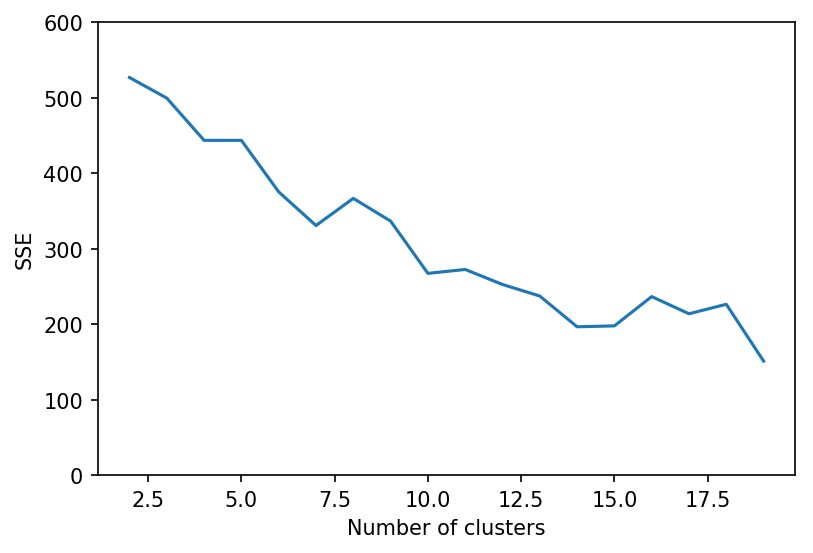

In [93]:
#Count Vectorizer

SSE = []

for k in range(2,20):
    km = MiniBatchKMeans(n_clusters = k, random_state = 42)
    km.fit(nmf_cv_data)
    labels = km.labels_
    SSE.append(km.inertia_)
    
plt.figure(dpi = 150)
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.plot(range(2,20),SSE);
plt.ylim((0,600))

plt.savefig("cluster_plot")

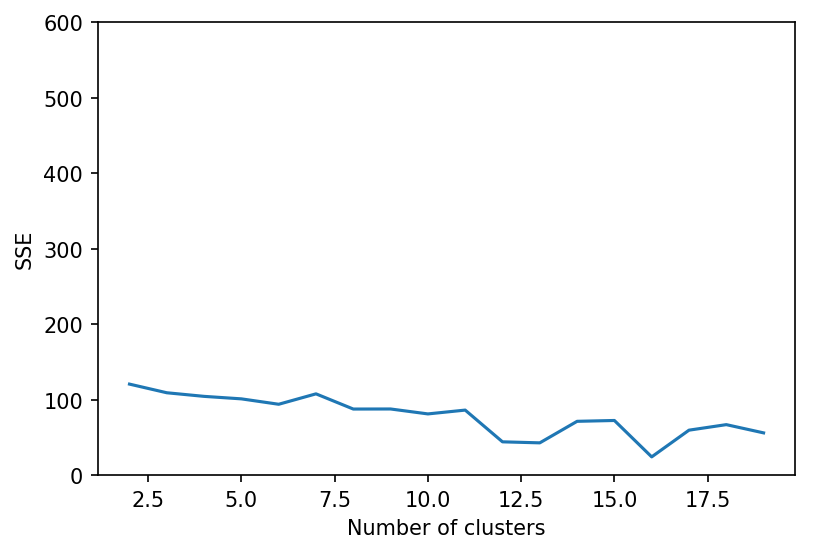

In [94]:
#TFIDF

SSE = []

for k in range(2,20):
    km = MiniBatchKMeans(n_clusters = k, random_state = 42)
    km.fit(nmf_tfidf_data)
    labels = km.labels_
    SSE.append(km.inertia_)
    
plt.figure(dpi = 150)
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.plot(range(2,20),SSE);
plt.ylim((0,600))

plt.savefig("cluster_plot")

In [105]:
km = MiniBatchKMeans(n_clusters=6)
nmf_clusters = km.fit_predict(nmf_cv_data)

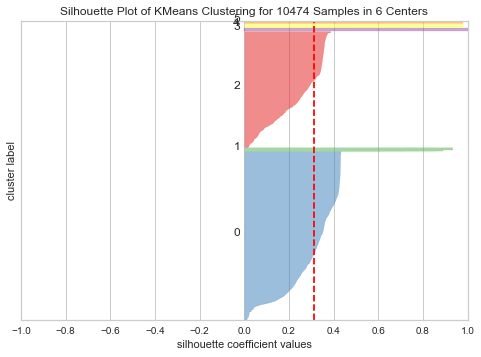

In [120]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
visualiser = SilhouetteVisualizer(KMeans(n_clusters=6))
visualiser.fit(nmf_cv_data)
visualiser.poof()

In [104]:
model = TSNE(n_components=2, random_state = 0, verbose = 0)
low_data = model.fit_transform(nmf_cv_data)

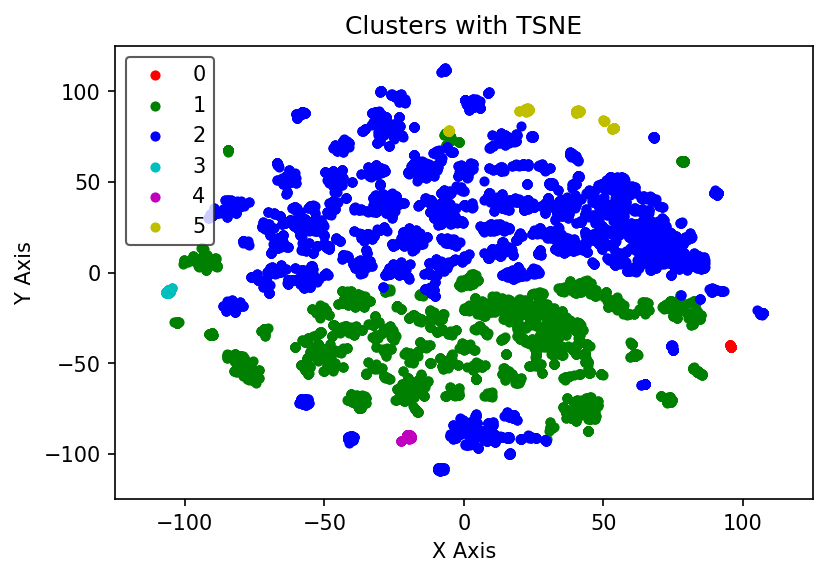

In [106]:
colors = (['r','g','b','c','m','y'])
plt.figure(dpi = 150)

for i, c, label in zip (range(6), colors, list(range(6))):
    plt.scatter(low_data[nmf_clusters == i, 0], low_data[nmf_clusters == i, 1], c=c, label = label, s = 15, alpha = 1)

plt.legend(fontsize = 10, loc = 'upper left', frameon = True, facecolor = '#FFFFFF', edgecolor = '#333333');
plt.title("Clusters with TSNE", fontsize = 12);
plt.xlim(-125,125);
plt.ylim(-125,125);
plt.ylabel("Y Axis");
plt.xlabel("X Axis");
plt.yticks(fontsize =10);
plt.xticks(fontsize = 10);

In [111]:
km_tfidf = MiniBatchKMeans(n_clusters=6)
nmf_tfidf_clusters = km_tfidf.fit_predict(nmf_tfidf_data)

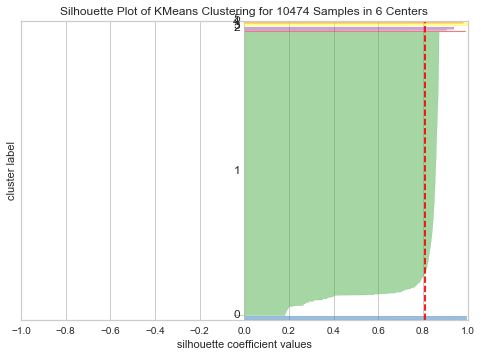

In [118]:
visualiser_tfidf = SilhouetteVisualizer(KMeans(n_clusters=6))
visualiser_tfidf.fit(nmf_tfidf_data)
visualiser_tfidf.poof()

In [112]:
model_2 = TSNE(n_components=2, random_state = 0, verbose = 0)
low_data_2 = model_2.fit_transform(nmf_tfidf_data)

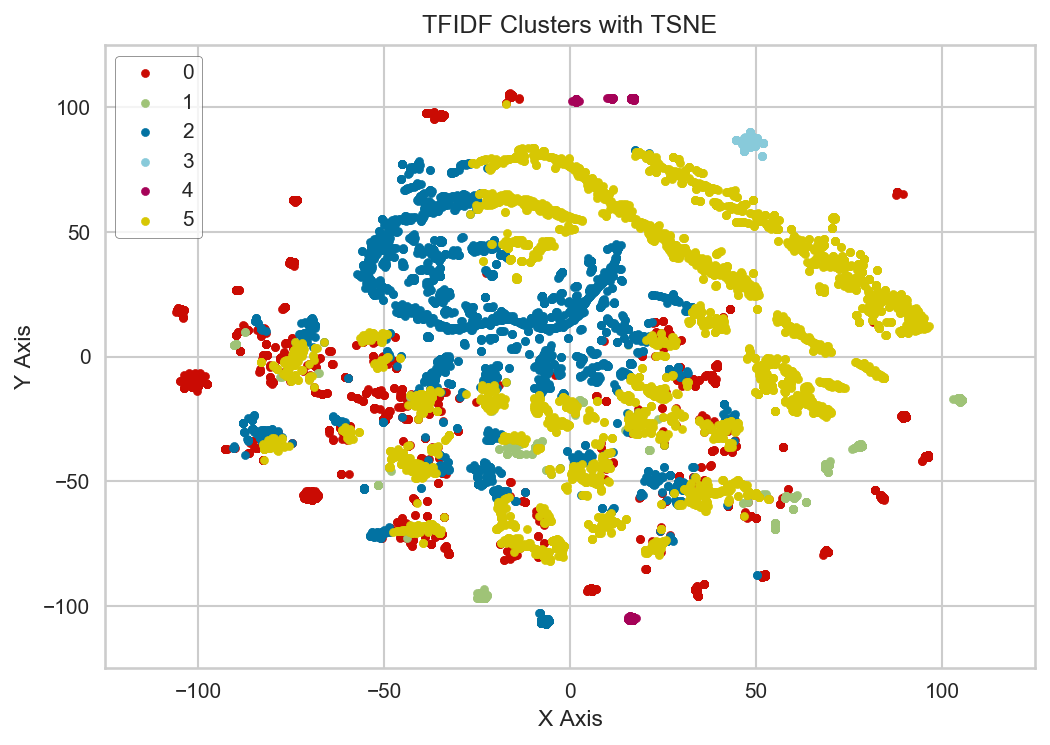

In [113]:
colors = (['r','g','b','c','m','y'])
plt.figure(dpi = 150)

for i, c, label in zip (range(6), colors, list(range(6))):
    plt.scatter(low_data_2[nmf_tfidf_clusters == i, 0], low_data_2[nmf_tfidf_clusters == i, 1], c=c, label = label, s = 15, alpha = 1)

plt.legend(fontsize = 10, loc = 'upper left', frameon = True, facecolor = '#FFFFFF', edgecolor = '#333333');
plt.title("TFIDF Clusters with TSNE", fontsize = 12);
plt.xlim(-125,125);
plt.ylim(-125,125);
plt.ylabel("Y Axis");
plt.xlabel("X Axis");
plt.yticks(fontsize =10);
plt.xticks(fontsize = 10);

In [131]:
#need to clean tweet

def get_more_tweets(input_tweet, model, vectorizer, data_vectors):
    new_vec = model.transform(
        vectorizer.transform([input_tweet]))
    nn = NearestNeighbors(n_neighbors=10, metric='cosine', algorithm='brute')
    nn.fit(data_vectors)
    results = nn.kneighbors(new_vec)
    return results[1][0]

In [150]:
def print_more_tweets(input_tweet,recommend_list):
    print(input_tweet)
    print('\n------\n')
    for tweet in recommend_list:
        print('\n --- Result --- \n')
        print(uncleaned_tweets[tweet])

In [134]:
first_tweet = sustainability_collection.find_one({})['text']

In [154]:
uncleaned_tweets[:20]

['RT @angelurena: This visit concludes this week’s stops in Miami and the Caribbean by President @BillClinton to promote sustainability and r…',
 'Are you in Melbourne or Sydney? Join us at #SPFAustralia to learn about the latest trends in #EHS, #RiskManagement… https://t.co/BG7eWM1FCO',
 'Why Vienna Does So Well on Quality-of-Life Rankings #affordablehousing #publictransport #sustainability https://t.co/xLQASUUqoc',
 'RT @APLShipping: APL achieved a 50.7% reduction in CO2 emissions per transported container per kilometre in 2017, as compared to 2009. Read…',
 "RT @AmazonWatch: “Hydroelectricity may appear relatively 'clean' but the process in which a mega-dam is built is far from it... #BeloMonte…",
 'RT @cleanAirGurgaon: Right to Clean Enviornment also comes with immense responsibility as;Citizens, Consumers,Producers,we thank all who ha…',
 'RT @thefishsite: A new study suggests seafood consumers across the globe are united in thinking that the biggest threat to the oceans is po…',


In [145]:
rec_list = get_more_tweets(first_tweet, nmf_tfidf_model, tfidf_vectorizer, nmf_tfidf_data)

In [151]:
print_more_tweets(first_tweet,rec_list)

RT @angelurena: This visit concludes this week’s stops in Miami and the Caribbean by President @BillClinton to promote sustainability and r…

------


 --- Result --- 

RT @angelurena: This visit concludes this week’s stops in Miami and the Caribbean by President @BillClinton to promote sustainability and r…

 --- Result --- 

RT @Carbon3IT: Got an interesting call later, super secret, all will be revealed in time #datacentre #greenit #Sustainability

 --- Result --- 

RT @Ecolab: How did our head of #sustainability, @EmilioTenuta, become so passionate about #waterscarcity? It all started with his family’s…

 --- Result --- 

RT @jameskennell: You can see the CFP for our special issue on ‘tourism, governance and sustainability’ on the @Sus_MDPI website - DM for i…

 --- Result --- 

RT @jameskennell: You can see the CFP for our special issue on ‘tourism, governance and sustainability’ on the @Sus_MDPI website - DM for i…

 --- Result --- 

RT @womensart1: US based artist Mary Mattingly

In [153]:
rec_list2 = get_more_tweets(uncleaned_tweets[6], nmf_tfidf_model, tfidf_vectorizer, nmf_tfidf_data)
print_more_tweets(uncleaned_tweets[6],rec_list2)

RT @thefishsite: A new study suggests seafood consumers across the globe are united in thinking that the biggest threat to the oceans is po…

------


 --- Result --- 

RT @thefishsite: A new study suggests seafood consumers across the globe are united in thinking that the biggest threat to the oceans is po…

 --- Result --- 

Would You Go?!
#aloha #spirit #passion #surfing #bigwaves #barrels #surfer #teahupoo #bigwave #surf #ocean #oceans… https://t.co/E8wwoAy5x7

 --- Result --- 

Well done @EdwardsandBlake for doing a beach clean this weekend 🐟 🐠 🐡 🐙 🐚 🐬 🐳 🐋 
#cleanoceans #lessplastic… https://t.co/fkAUJyGcCQ

 --- Result --- 

If you’re in Vegas Aug. 21-24th .@ErgoExpo @ParisVegas please stop by booth 210 and learn how  Blickle Economics =… https://t.co/v1hlrXwiIZ

 --- Result --- 

Be responsible not only for doing things well but for encouraging others to do well also. Sharing values and purpos… https://t.co/5ovG7Wxla4

 --- Result --- 

Quick stop to @urbanwhyte in Devon AB Love

In [163]:
rec_list3 = get_more_tweets(uncleaned_tweets[4000], nmf_tfidf_model, tfidf_vectorizer, nmf_tfidf_data)
print_more_tweets(uncleaned_tweets[4000],rec_list3)

"There are only two types of farmers: regenerative, or destructive. We don't even talk about sustainability anymore… https://t.co/OF142kRRWC

------


 --- Result --- 

"There are only two types of farmers: regenerative, or destructive. We don't even talk about sustainability anymore… https://t.co/OF142kRRWC

 --- Result --- 

Are you interested in #sustainability or #communitydevelopment? Register with #TEP today and be a part of our inten… https://t.co/cblCBP98wf

 --- Result --- 

WeWork takes sustainability to the next level by banning meat at corporate events, aiming for carbon-neutrality, an… https://t.co/enxTFkqSfj

 --- Result --- 

Please join us for an exciting ONE plenary on Combatting Sustainability the Spiral of Silence.  Taking place at the… https://t.co/dC2BSPFAW9

 --- Result --- 

Dear @MoJGovUK, I understand your new buzz word is "sustainability". That the penny has finally. Forgive my cynicis… https://t.co/dpAaS1KwSh

 --- Result --- 

Riva shares a deep commitment t

In [168]:
rec_list4 = get_more_tweets(uncleaned_tweets[9000], nmf_tfidf_model, tfidf_vectorizer, nmf_tfidf_data)
print_more_tweets(uncleaned_tweets[9000],rec_list4)

"The End Game for a Truly Planetary Society" Geoffrey Holland https://t.co/FlgBE57ApM #sustainability #environment

------


 --- Result --- 

"The End Game for a Truly Planetary Society" Geoffrey Holland https://t.co/FlgBE57ApM #sustainability #environment

 --- Result --- 

How climate is changing
https://t.co/OY0Y85su5E via @Horyou 
#climate #environment #sustainability

 --- Result --- 

Africa is planting millions of trees to create a Great Green Wall
#deforestation  #innovation #environment… https://t.co/fZDj1RVWnY

 --- Result --- 

Africa is planting millions of trees to create a Great Green Wall
#deforestation  #innovation #environment… https://t.co/ra6DUhZxR6

 --- Result --- 

Africa is planting millions of trees to create a Great Green Wall
#deforestation  #innovation #environment… https://t.co/ie1M2Wyqyl

 --- Result --- 

Jai Hind!Pics ...#India #Ideas #Innovation #Intellect #Hariyali #Sustainability #Environment #Scene #Philosophy… https://t.co/8prB3GeV7j

 --- Result --

In [183]:
rec_list5 = get_more_tweets(uncleaned_tweets[3250], nmf_tfidf_model, tfidf_vectorizer, nmf_tfidf_data)
print_more_tweets(uncleaned_tweets[3250],rec_list5)

RT @ksanderson727: #fourthwave Great example of making data accessible to drive #deforestation action. Thanks @TraseEarth https://t.co/TCHq…

------


 --- Result --- 

RT @ksanderson727: #fourthwave Great example of making data accessible to drive #deforestation action. Thanks @TraseEarth https://t.co/TCHq…

 --- Result --- 

RT @ksanderson727: #fourthwave Great example of making data accessible to drive #deforestation action. Thanks @TraseEarth https://t.co/TCHq…

 --- Result --- 

RT @ksanderson727: #fourthwave Great example of making data accessible to drive #deforestation action. Thanks @TraseEarth https://t.co/TCHq…

 --- Result --- 

RT @ksanderson727: #fourthwave Great example of making data accessible to drive #deforestation action. Thanks @TraseEarth https://t.co/TCHq…

 --- Result --- 

RT @ksanderson727: #fourthwave Great example of making data accessible to drive #deforestation action. Thanks @TraseEarth https://t.co/TCHq…

 --- Result --- 

Come to the Sustainable and Res